<a href="https://colab.research.google.com/github/ftk1000/w2v_ftk1000/blob/master/Copy_of_w2v_tf_fast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# w2v QUICK DEMO

In [1]:
# w2v_tf_fast
import numpy as np
import pandas as pd
pd.options.display.max_columns = 500
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
from keras import models
from keras import layers 
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import time
import re   # p = re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', p)

def get_padding(x):
  return (np.max(x)-np.min(x))/20


def plot_words(w2v_df, ttl):
  # plot words according to their embedding
  x1 = np.array(w2v_df['x1'])
  x2 = np.array(w2v_df['x2'])
  # wrd = 
  x_axis_min, x_axis_max = np.min(x1)-get_padding(x1), np.max(x1)+get_padding(x1)
  y_axis_min, y_axis_max = np.min(x2)-get_padding(x2), np.max(x2)+get_padding(x2)

  plt.close()
  fig, ax = plt.subplots()
  plt.rcParams["figure.figsize"] = (10,10)
  # plt.figure(figsize=(10,10))

  plt.scatter(x1, x2, c='red', s=500, alpha=0.3)
  # plt.text(x1+.03, x2+.03, np.asarray(w2v_df['word']), fontsize=9)
  for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    if word != 'кичлам':
      ax.annotate(word, (x1,x2 ), fontsize=14, color='blue')
      
  ix  =  w2v_df['word']=='кичлам'
  if np.sum(ix)==1:
    [_,w,wx1,wx2] = np.asarray(w2v_df.loc[ix])[0]
    ax.annotate(w, (wx1,wx2 ), fontsize=16, color='red')

  plt.xlim(x_axis_min,x_axis_max)
  plt.ylim(y_axis_min,y_axis_max)
  plt.title(ttl, fontsize=18)
  plt.show()

def show_weights(model):
  print('WEIGHT MATRICES:')
  for layer in model.layers:
      weights = layer.get_weights() # list
      print(weights[0].shape)
      print(weights[0])

  print('\n\nBIASES:')
  for layer in model.layers:
      bias = layer.bias # list
      print(bias.shape)
      print(bias)    

def show_weights_v2(model, format='rounded'):
  W0=(model.layers[0].get_weights()[0])
  W1=(model.layers[1].get_weights()[0])
  b0 = np.asarray(model.layers[0].bias).astype(float)
  b1 = np.asarray(model.layers[1].bias).astype(float)
  if format=='rounded':
    print("W0=",np.round(W0,1))
    print("W1=",np.round(W1,1))
    print("b0=",np.round(b0,1))
    print("b1=",np.round(b1,1))
  else:
    print("W0=",W0)
    print("W1=",W1)
    print("b0=",b0)
    print("b1=",b1)


In [2]:
def plot_words_v0(W, vocab, ttl):
  # plot words according to their embedding
  x1 = W[:,0]
  x2 = W[:,1]
  # wrd = 
  x_axis_min, x_axis_max = np.min(x1)-get_padding(x1), np.max(x1)+get_padding(x1)
  y_axis_min, y_axis_max = np.min(x2)-get_padding(x2), np.max(x2)+get_padding(x2)

  plt.close()
  fig, ax = plt.subplots()
  plt.rcParams["figure.figsize"] = (10,10)
  # plt.figure(figsize=(10,10))

  plt.scatter(x1, x2, c='red', s=500, alpha=0.3)
  # plt.text(x1+.03, x2+.03, np.asarray(w2v_df['word']), fontsize=9)
  for word, x1i, x2i in zip(vocab, x1, x2):
    if word != 'кичлам':
      ax.annotate(word, (x1i,x2i ), fontsize=14, color='blue')
    else:
      ax.annotate(word, (x1i,x2i ), fontsize=16, color='red')
      
  plt.xlim(x_axis_min,x_axis_max)
  plt.ylim(y_axis_min,y_axis_max)
  plt.title(ttl, fontsize=18)
  plt.show()

In [3]:
MODE = 'ENGLISH'
# MODE = 'RUSSIAN'

if MODE=='RUSSIAN':
  text = "Балерина вдохновляет девочку. КИЧЛАМ сильный и ловкий. Штангист сильный мужчина. Балерина красивая женщина. Юниор ловкий штангист. \
          Юниор молодой мужчина. Девочку учит балерина."

  # text = "Балерина вдохновляет девочку. КИЧЛАМ ловкий, и у него есть сила. Мужчина - штангист, он - сила. Эта женщина - балерина, она красивая. \
  # Этот юниор - начинающий штангист. Юниор молодой мужчина. Девочку учит балерина."
  # corpus = [s.lower().replace('- ','').replace(',','').strip() for s in re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', text)[0].split('.')[:-1] ]
  
elif MODE=='ENGLISH':
  text = "Fish swim in deep water. Ocean is very deep. Fish swim in darkness. \
          Birds are high in the sky. Birds fly very high. On a sunny day the sky is full of light."

  # corpus = [s.lower().strip().split() for s in re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', text)[0].split('.')[:-1] ]
samples = text.split('.')
corpus=[s.lower().strip() for s in samples][:-1]
corpus

['fish swim in deep water',
 'ocean is very deep',
 'fish swim in darkness',
 'birds are high in the sky',
 'birds fly very high',
 'on a sunny day the sky is full of light']

In [4]:
def remove_stop_words(corpus):
    stop_words = ['in','very','are','the','to','of','is', 'a', 'on','will', 'be', 'и', 'он', 'этот', 'она']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    return results

corpus = remove_stop_words(corpus)
corpus

['fish swim deep water',
 'ocean deep',
 'fish swim darkness',
 'birds high sky',
 'birds fly high',
 'sunny day sky full light']

# Create VOCABULARY, count words

In [5]:
sentences = [s.split(' ') for s in corpus]
word_count = {}
vocab=[]
for ss in sentences:
  # print(ss)
  vocab += ss
vocab = sorted(set(vocab))

# initialize word_count dictionary
word_count = {}
for w in vocab:
  word_count[w]=0

Num_all_words=0
for w in vocab:
  for ss in sentences:
    Num_all_words += len(ss)
    for sw in ss:
      if sw==w:
        word_count[w] += 1
# Num_all_words = sum(list(word_count.values()))
df_vocab = pd.DataFrame({'word': list(word_count.keys()),   'count': list(word_count.values())})
df_vocab['freq'] = df_vocab['count']/np.sum(df_vocab['count'])
df_vocab

,word,count,freq
0,birds,2,0.10
1,darkness,1,0.05
2,day,1,0.05
3,deep,2,0.10
4,fish,2,0.10
5,fly,1,0.05
6,full,1,0.05
7,high,2,0.10
8,light,1,0.05
9,ocean,1,0.05


In [6]:
# sentences = [s.split(' ') for s in corpus]

# vocab=[]
# for ss in sentences:
#   vocab += ss
# vocab = sorted(set(vocab))

# initialize dictionary of context words
context_words = {}
for w in vocab:
  context_words[w] = []

word2int = {}
for i,word in enumerate(vocab):
    word2int[word] = i
# print('word2int=', word2int)

WINDOW_SIZE = 2
data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])
                context_words[word].append(neighbor)

df_context_words = pd.DataFrame({'word': list(context_words.keys()),   'c_words': list(context_words.values())})
df_context_words['num_c_words_pairs'] = [ len(wrds) for wrds in list(context_words.values()) ]
df_context_words['set_c_words'] = [ set(wrds) for wrds in list(context_words.values()) ]
df_context_words['num_c_words'] = [ len(set(wrds)) for wrds in list(context_words.values()) ]
# df_context_words


In [7]:
df_vocab = df_vocab.merge( df_context_words, how='outer',on=['word'] )
df_vocab

,word,count,freq,c_words,num_c_words_pairs,set_c_words,num_c_words
0,birds,2,0.10,"[high, sky, fly, high]",4,"{sky, fly, high}",3
1,darkness,1,0.05,"[fish, swim]",2,"{swim, fish}",2
2,day,1,0.05,"[sunny, sky, full]",3,"{sunny, sky, full}",3
3,deep,2,0.10,"[fish, swim, water, ocean]",4,"{ocean, swim, water, fish}",4
4,fish,2,0.10,"[swim, deep, swim, darkness]",4,"{swim, darkness, deep}",3
5,fly,1,0.05,"[birds, high]",2,"{birds, high}",2
6,full,1,0.05,"[day, sky, light]",3,"{light, sky, day}",3
7,high,2,0.10,"[birds, sky, birds, fly]",4,"{birds, sky, fly}",3
8,light,1,0.05,"[sky, full]",2,"{sky, full}",2
9,ocean,1,0.05,[deep],1,{deep},1


# CREATE WORD PAIRS FOR TRAINING

In [8]:
df = pd.DataFrame(data, columns = ['input', 'label'])

print(f'{len(vocab)} слов; СЛОВАРЬ=', vocab)
print( f'Pазмер окна = {WINDOW_SIZE}, {len(df)} контекстные пары слов')
print(sentences)
df.head()
# df.head(n=len(df))

w2idx = pd.DataFrame.from_dict({ 'values': word2int.values(), 'word': word2int.keys() })

print('w2idx.shape=', w2idx.shape)
print('w2idx.head()=', w2idx.head())





ONE_HOT_DIM = len(vocab)
print('ONE_HOT_DIM = ', ONE_HOT_DIM)
# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word


# print('df.head()=', df.head())
# print('word2int=', word2int)
# k=0
for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))
    # if k<5:
    #   Xtmp = to_one_hot_encoding(word2int[ x ])
    #   Ytmp = to_one_hot_encoding(word2int[ y ])
    #   print(x,'\t===>',Xtmp, '\t\t\t\t',  y ,'===>',Ytmp)
    #   k+=1

# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)
df['X_train']=list(X_train)
df['Y_train']=list(Y_train)
# df.head()
dfint = df.copy()
dfint['X_train']=list(X_train.astype(int))
dfint['Y_train']=list(Y_train.astype(int))

print('dfint.shape=', dfint.shape)
print('dfint.head()=')
dfint.head()

14 слов; СЛОВАРЬ= ['birds', 'darkness', 'day', 'deep', 'fish', 'fly', 'full', 'high', 'light', 'ocean', 'sky', 'sunny', 'swim', 'water']
Pазмер окна = 2, 44 контекстные пары слов
[['fish', 'swim', 'deep', 'water'], ['ocean', 'deep'], ['fish', 'swim', 'darkness'], ['birds', 'high', 'sky'], ['birds', 'fly', 'high'], ['sunny', 'day', 'sky', 'full', 'light']]
w2idx.shape= (14, 2)
w2idx.head()=    values      word
0       0     birds
1       1  darkness
2       2       day
3       3      deep
4       4      fish
ONE_HOT_DIM =  14
dfint.shape= (44, 4)
dfint.head()=


,input,label,X_train,Y_train
0,fish,swim,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
1,fish,deep,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,swim,fish,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,swim,deep,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,swim,water,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"


In [9]:
vocab

['birds',
 'darkness',
 'day',
 'deep',
 'fish',
 'fly',
 'full',
 'high',
 'light',
 'ocean',
 'sky',
 'sunny',
 'swim',
 'water']

# Show the GRAPH before embedding

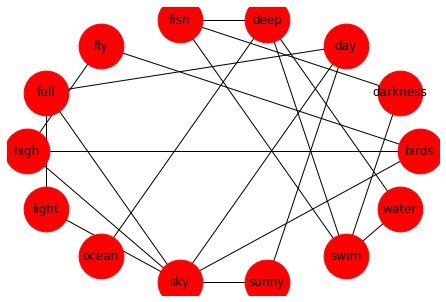

In [22]:
%matplotlib inline
import networkx as nx
G = nx.Graph()
for i in range(len(vocab)):
  G.add_node(vocab[i])       # adds node "spam"

# G.add_edge('sky','fly')
# G.add_edge('a','spam')

for i in range(len(dfint)):
  G.add_edge(dfint.input[i], dfint.label[i] )

# basic graph drawing capability
import matplotlib.pyplot as plt
# nx.draw(G)
# color = ['red', 'blue']*7
color='red'
nx.draw_circular(G, with_labels=True, node_size=2000, node_color=color)  

In [23]:
# # VISUALIZE

# ![words_p1.JPG](https://github.com/ftk1000/w2v_ftk1000/blob/master/words_p1.JPG?raw=1)<br>
# ![words_p2.JPG](https://github.com/ftk1000/w2v_ftk1000/blob/master/words_p2.JPG?raw=1)

In [10]:
# !pip install graphviz
from graphviz import Digraph

# create a graph object
dot = Digraph(comment='words')

for i in range(len(vocab)):
  # word_node = f'word_{i}'
  # dot.node(  word_node,  vocab[i]  )
  dot.node(  vocab[i],  vocab[i]  )

for i in range(len(dfint)):
  dot.edge(   dfint.input[i],    dfint.label[i], constraint='false' )

dot.render('junk', view=True)


'junk.pdf'

# MODEL

In [62]:
def get_weights(model):
  # W0,W1,b0,b1
  W0=(model.layers[0].get_weights()[0])
  W1=(model.layers[1].get_weights()[0])
  # # print("W0=",W0)
  # # print("W1=",W1)
  # print("W0=",np.round(W0,1))
  # print("W1=",np.round(W1,1))

  b0 = np.asarray(model.layers[0].bias).astype(float)
  b1 = np.asarray(model.layers[1].bias).astype(float)
  # # print("b0=",b0)
  # # print("b1=",b1)
  # print("b0=",np.round(b0,1))
  # print("b1=",np.round(b1,1))

  return W0,W1,b0,b1

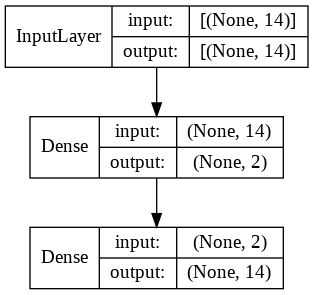

In [63]:
model = models.Sequential()
# https://www.tensorflow.org/api_docs/python/tf/keras/activations   # network.add( layers.Dense(2, activation='relu', input_shape=(12,) ) )
model.add( layers.Dense(2, activation='linear', input_shape=(ONE_HOT_DIM,) ) )
model.add( layers.Dense(ONE_HOT_DIM, activation='softmax' ) )
model.compile( optimizer='rmsprop', 
                 loss = 'categorical_crossentropy', 
                 metrics = ['accuracy'] )
plot_model(model, show_shapes=1, show_dtype=0,show_layer_names=0)              # plot_model(model, show_shapes=1, show_layer_names=1)

[0. 0.]


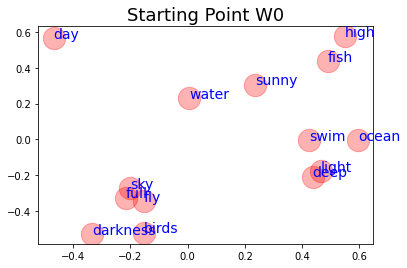

In [64]:
W0,W1,b0,b1=get_weights(model)
print(b0)
%matplotlib inline
plot_words_v0(W0, vocab, ttl='Starting Point W0')

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


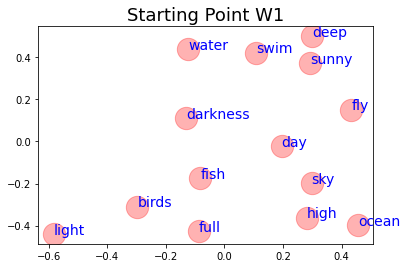

In [65]:
# W1.transpose()
%matplotlib inline
print(b1)
plot_words_v0(W=W1.transpose(), vocab=vocab, ttl='Starting Point W1')
# W1

# Loss Function - Categorical Cross Entropy

The Skip-Gram Model defines the embedding vector of every word by the matrix W0 and the context vector by the output matrix W1. Given an input word I, let us label the corresponding row of W as vector $v_I$ (embedding vector) and its corresponding column of O as $v_O$ (context vector). 



In [66]:
# W0

In [67]:
vi=W0[0,:]
print('vi=',vi)

vi= [-0.15327531 -0.52083397]


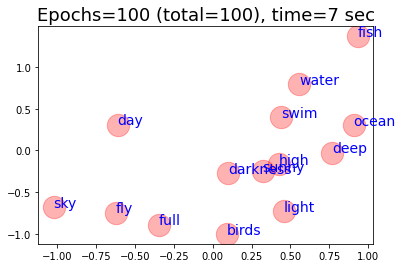

In [68]:
%matplotlib inline
# EPOCHS = 100
total_epochs = 0

def model_fit_n_show(model, eps=100):
  global total_epochs
  sttime = time.time()
  model.fit( X_train, Y_train, epochs=eps, batch_size=1, verbose=0)
  d2 = pd.DataFrame(  model.weights[0].numpy(),  columns = ['x1', 'x2'] )
  w2v_df = pd.concat( [w2idx,d2],axis=1 )
  # ?network.fit
  endtime = time.time()
  total_epochs += eps 
  ttl = f'Epochs={eps} (total={total_epochs}), time={int(endtime-sttime)} sec'
  # print(ttl)
  # plot_words_v0(w2v_df, ttl)
  plot_words(w2v_df, ttl)
  return model, w2v_df, total_epochs

model, w2v_df, total_epochs = model_fit_n_show(model,eps=100)
W0,W1,b0,b1 = get_weights(model)
# print("b0=",np.round(b0,1))
# print("b1=",np.round(b1,1))

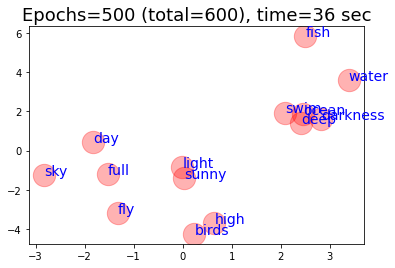

In [69]:
%matplotlib inline
model, w2v_df, total_epochs = model_fit_n_show(model,eps=500)
W0,W1,b0,b1 = get_weights(model)
# print("b0=",np.round(b0,1))
# print("b1=",np.round(b1,1))

# Show bi-partite graph

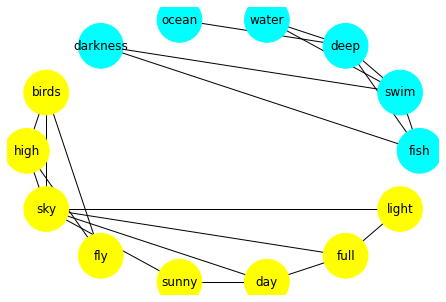

In [21]:
fish_words = ['fish',  'swim', 'deep', 'water', 'ocean', 'darkness']
bird_words = ['birds', 'high', 'sky',  'fly',   'sunny', 'day',      'full', 'light']

%matplotlib inline
import networkx as nx
G = nx.Graph()
for i in range(len(fish_words)):
  G.add_node(fish_words[i])       # adds node "spam"
for i in range(len(bird_words)):
  G.add_node(bird_words[i])       # adds node "spam"

# G.add_edge('sky','fly')
# G.add_edge('a','spam')

for i in range(len(dfint)):
  G.add_edge(dfint.input[i], dfint.label[i] )

# basic graph drawing capability
import matplotlib.pyplot as plt
# nx.draw(G)
colors = ['cyan']*len(fish_words) +  ['yellow']*len(bird_words)

nx.draw_circular(G, with_labels=True, node_size=2000, node_color=colors)  

# Compare W0 and W1

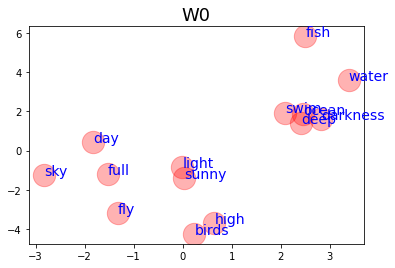

In [70]:
W0,W1,b0,b1 = get_weights(model)

W=pd.DataFrame(W0, columns=['x1','x2'])
W['word'] = vocab.copy()
W['values'] =w2v_df['values'].copy()
W = W.reindex(columns=w2v_df.columns)

%matplotlib inline
plot_words(W, ttl='W0')

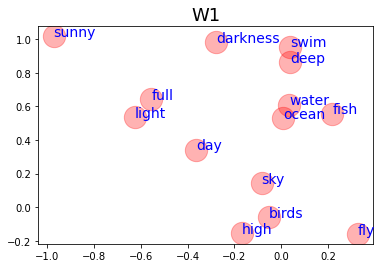

In [71]:
W=pd.DataFrame(np.transpose(W1), columns=['x1','x2'])
W['word'] = vocab.copy()
W['values'] =w2v_df['values'].copy()
W = W.reindex(columns=w2v_df.columns)

%matplotlib inline
plot_words(W, ttl='W1')

In [72]:
# w=vocab[0]
# ix =  dfint['input'] == w
# dfint.head()
# # print(dfint.loc[ix, ['Y_train']])
# np.asarray(np.sum( dfint.loc[ix, ['Y_train']], axis=0 ))[0]

# MATRIX FACTORIZATION

In [73]:
# adjacency matrix
adjM = []
for w in vocab:
  # print(w)
  row = np.array(np.sum( dfint.loc[ dfint['input'] == w, ['Y_train']], axis=0 ))[0]
  adjM.append(row)
np.asmatrix(adjM)

matrix([[0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

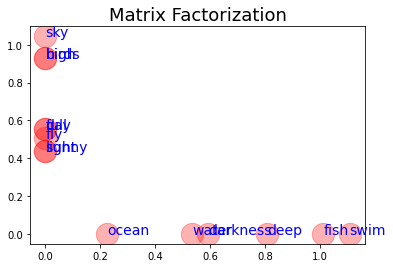

In [74]:
from sklearn.decomposition import NMF
NMF_Model = NMF(n_components=2, init='random', random_state=0)
W = NMF_Model.fit_transform(adjM)
H = NMF_Model.components_
W=pd.DataFrame(W, columns=['x1','x2'])
W['word'] = vocab.copy()
W['values'] =w2v_df['values'].copy()
W = W.reindex(columns=w2v_df.columns)

%matplotlib inline
plot_words(W, ttl='Matrix Factorization')

In [75]:
print(W[['word','x1','x2']])

        word            x1        x2
0      birds  0.000000e+00  0.928300
1   darkness  5.931192e-01  0.000000
2        day  0.000000e+00  0.554594
3       deep  8.061596e-01  0.000000
4       fish  1.011610e+00  0.000000
5        fly  8.867872e-09  0.505751
6       full  0.000000e+00  0.554594
7       high  2.545033e-08  0.928297
8      light  0.000000e+00  0.435859
9      ocean  2.256103e-01  0.000000
10       sky  0.000000e+00  1.045384
11     sunny  0.000000e+00  0.435859
12      swim  1.107730e+00  0.000000
13     water  5.356149e-01  0.000000


# SVD

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

In [76]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
# X = sparse_random(100, 100, density=0.01, format='csr', random_state=42)
svd = TruncatedSVD(n_components=12, n_iter=7, random_state=42)
svd.fit(adjM)
print('svd.explained_variance_ratio_ = ', svd.explained_variance_ratio_)
print('svd.explained_variance_ratio_.sum() = ',  svd.explained_variance_ratio_.sum())
print('svd.singular_values_ = ',  svd.singular_values_)

svd.explained_variance_ratio_ =  [0.16392027 0.20142377 0.12841928 0.1291718  0.09929078 0.09076257
 0.06498666 0.06355666 0.02156477 0.01306188 0.01064691 0.00948143]
svd.explained_variance_ratio_.sum() =  0.9962867711853977
svd.singular_values_ =  [3.67091427 3.57321204 2.28958183 2.28662295 2.         1.92440219
 1.61803399 1.60057194 0.94117792 0.73737694 0.6631923  0.61803399]


# COMPUTE SOFTMAX

In [77]:
W0=(model.layers[0].get_weights()[0])
W1=(model.layers[1].get_weights()[0])
# # print("W0=",W0)
# # print("W1=",W1)
# print("W0=",np.round(W0,1))
# print("W1=",np.round(W1,1))

b0 = np.asarray(model.layers[0].bias).astype(float)
b1 = np.asarray(model.layers[1].bias).astype(float)
# # print("b0=",b0)
# # print("b1=",b1)
# print("b0=",np.round(b0,1))
# print("b1=",np.round(b1,1))

i=0
# x = w2v_df.loc[i, ['x1', 'x2'] ].astype(float)
# x = dfint.iloc[i, ['X_train'] ].astype(float)
x=dfint.X_train[i]
print('x=', x)
y=dfint.Y_train[i]
print('y=', y)



np.set_printoptions(precision=5)

yhat = np.matmul( np.matmul(x,W0)+b0,  W1 ) + b1
from scipy.special import softmax
print('yhat=', yhat)

sftmax_yhat = softmax(yhat)
print('sftmax_yhat=', sftmax_yhat)

np.sum(np.exp(yhat)/np.sum(np.exp(yhat))-sftmax_yhat)

x= [0 0 0 0 1 0 0 0 0 0 0 0 0 0]
y= [0 0 0 0 0 0 0 0 0 0 0 0 1 0]
yhat= [-3.35291  1.42879 -1.75391  2.2169   1.1063  -4.09862 -0.37999 -4.51737
 -1.89653 -1.34649 -1.50023 -0.06959  2.78812  0.21307]
sftmax_yhat= [9.62397e-04 1.14821e-01 4.76205e-03 2.52518e-01 8.31696e-02 4.56562e-04
 1.88139e-02 3.00357e-04 4.12909e-03 7.15704e-03 6.13710e-03 2.56616e-02
 4.47067e-01 3.40441e-02]


-2.2941717969793274e-16

In [78]:
dfint

,input,label,X_train,Y_train
0,fish,swim,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
1,fish,deep,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,swim,fish,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,swim,deep,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,swim,water,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
5,deep,fish,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
6,deep,swim,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
7,deep,water,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
8,water,swim,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
9,water,deep,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [79]:
# model.get_weights()
# model.weights

In [80]:
# # https://ai-pool.com/d/how-to-get-the-weights-of-keras-model-
# for layer in model.layers:
#     weights = layer.get_weights() # list

# from keras.models import Sequential
# model = Sequential()
# weights = model.get_weights() # returs a numpy list of weights  




In [81]:
W0=(model.layers[0].get_weights()[0])
W1=(model.layers[1].get_weights()[0])
# print("W0=",W0)
# print("W1=",W1)
print("W0=",np.round(W0,1))
print("W1=",np.round(W1,1))

b0 = np.asarray(model.layers[0].bias).astype(float)
b1 = np.asarray(model.layers[1].bias).astype(float)
# print("b0=",b0)
# print("b1=",b1)
print("b0=",np.round(b0,1))
print("b1=",np.round(b1,1))


W0= [[ 0.2 -4.3]
 [ 2.8  1.6]
 [-1.8  0.4]
 [ 2.4  1.4]
 [ 2.5  5.8]
 [-1.3 -3.2]
 [-1.5 -1.2]
 [ 0.6 -3.7]
 [-0.  -0.8]
 [ 2.5  1.9]
 [-2.8 -1.2]
 [ 0.  -1.4]
 [ 2.1  1.9]
 [ 3.4  3.6]]
W1= [[-0.1 -0.3 -0.4  0.   0.2  0.3 -0.6 -0.2 -0.6  0.  -0.1 -1.   0.   0. ]
 [-0.1  1.   0.3  0.9  0.6 -0.2  0.6 -0.2  0.5  0.5  0.1  1.   1.   0.6]]
b0= [-0.2  0.1]
b1= [-2.9 -3.8 -3.  -3.  -2.7 -3.9 -2.9 -3.2 -3.7 -4.5 -2.2 -3.9 -3.  -3.5]


In [82]:
# bias.value
# W0

In [83]:
# d2 = pd.DataFrame(  model.weights[0].numpy(),  columns = ['x1', 'x2'] )
d2 = pd.DataFrame(  np.round(W0,1),  columns = ['x1', 'x2'] )
w2v_df = pd.concat( [w2idx,d2],axis=1 )
w2v_df[['word',	'x1',	'x2']]

,word,x1,x2
0,birds,0.2,-4.3
1,darkness,2.8,1.6
2,day,-1.8,0.4
3,deep,2.4,1.4
4,fish,2.5,5.8
5,fly,-1.3,-3.2
6,full,-1.5,-1.2
7,high,0.6,-3.7
8,light,-0.0,-0.8
9,ocean,2.5,1.9


In [84]:
X_train[0].astype(int)


array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [85]:
import math
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def nearby_vectors(u,v, sign=1):
  uv = np.dot(u,v)
  siguv = sigmoid(sign*uv)
  logsiguv = np.log(siguv)
  print( 'u=',u,  '  v=',v)
  if sign==1:
      print( f'uv={np.round(uv,1)}, sig(uv)={siguv}, log(sig(uv))={logsiguv}')
  if sign == -1:
      print( f'uv={np.round(uv,1)}, sig(-uv)={siguv}, log(sig(-uv))={logsiguv}')
  return uv, siguv, logsiguv

x=np.array([1.1, -3.9])  # балерина
y=np.array([0.1, -4])    # девочку

noise_x = np.array([ [-0.1,3.2], [-0.2,2.8]  ])
xn0 = noise_x[0]

print('GOOD SOLUTION:')
nearby_vectors(x,y)
nearby_vectors(x, xn0, sign=-1)

print('\nBAD SOLUTION:')
nearby_vectors(x,y,-1)
nearby_vectors(x, xn0, sign=1)
a=2

GOOD SOLUTION:
u= [ 1.1 -3.9]   v= [ 0.1 -4. ]
uv=15.7, sig(uv)=0.9999998496049218, log(sig(uv))=-1.5039508947828205e-07
u= [ 1.1 -3.9]   v= [-0.1  3.2]
uv=-12.6, sig(-uv)=0.9999965941070496, log(sig(-uv))=-3.405898750514251e-06

BAD SOLUTION:
u= [ 1.1 -3.9]   v= [ 0.1 -4. ]
uv=15.7, sig(-uv)=1.5039507824588425e-07, log(sig(-uv))=-15.71000015039509
u= [ 1.1 -3.9]   v= [-0.1  3.2]
uv=-12.6, sig(uv)=3.405892950506343e-06, log(sig(uv))=-12.59000340589875


In [86]:
# import nltk
# from nltk import tokenize
# tokenize.sent_tokenize(p)



In [ ]:
np.asarray(w2v_df['word'])

array(['queen', 'woman', 'wise', 'boy', 'strong', 'prince', 'pretty',
       'man', 'king', 'princess', 'girl', 'young'], dtype=object)

In [ ]:
# [(x, y) for x in [1,2,3] for y in [3,1,4] if x != y]
sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
sentences


[['king', 'strong', 'man'],
 ['queen', 'wise', 'woman'],
 ['boy', 'young', 'man'],
 ['girl', 'young', 'woman'],
 ['prince', 'young', 'king'],
 ['princess', 'young', 'queen'],
 ['man', 'strong'],
 ['woman', 'pretty'],
 ['prince', 'boy', 'king'],
 ['princess', 'girl', 'queen']]

In [ ]:

sentences

[['king', 'strong', 'man'],
 ['queen', 'wise', 'woman'],
 ['boy', 'young', 'man'],
 ['girl', 'young', 'woman'],
 ['prince', 'young', 'king'],
 ['princess', 'young', 'queen'],
 ['man', 'strong'],
 ['woman', 'pretty'],
 ['prince', 'boy', 'king'],
 ['princess', 'girl', 'queen']]

In [ ]:
layer.bias

<tf.Variable 'dense_9/bias:0' shape=(12,) dtype=float32, numpy=
array([-3.2867498, -5.0678787, -3.9071274, -3.654713 , -2.8057609,
       -2.935007 , -2.2635174, -4.059876 , -2.541485 , -3.355741 ,
       -2.9069571, -2.9273875], dtype=float32)>

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

In [ ]:
ww

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

In [ ]:
ww=set();
[ww.union((set(ss))) for ss in [s.split(' ') for s in corpus]]

[{'king', 'man', 'strong'},
 {'queen', 'wise', 'woman'},
 {'boy', 'man', 'young'},
 {'girl', 'woman', 'young'},
 {'king', 'prince', 'young'},
 {'princess', 'queen', 'young'},
 {'man', 'strong'},
 {'pretty', 'woman'},
 {'boy', 'king', 'prince'},
 {'girl', 'princess', 'queen'}]

In [ ]:
np.round(np.matmul(W0,W1), 1)

array([[ 0.4,  1.2,  1.8,  0.9, -2. ,  1.2, -2.1, -0.7, -1.8, -0.8,  1. ,
        -1.9, -0.4],
       [ 2. ,  1.3,  1.2,  1.2,  0.1,  1.4, -0.1, -0.1, -0.4, -0.1,  1.3,
        -0.2, -0.3],
       [ 3.6,  2.3,  2. ,  2.1,  0.5,  2.3,  0. , -0.2, -0.5, -0.1,  2.3,
        -0.1, -0.6],
       [ 2.8,  1.9,  1.9,  1.8, -0. ,  2. , -0.4, -0.3, -0.7, -0.2,  1.9,
        -0.4, -0.5],
       [-0.4, -0.6, -0.8, -0.5,  0.7, -0.6,  0.7,  0.3,  0.7,  0.3, -0.5,
         0.7,  0.2],
       [ 2.8,  1.8,  1.5,  1.6,  0.5,  1.8,  0.1, -0.1, -0.3, -0. ,  1.8,
        -0. , -0.4],
       [-1.3, -1. , -1.1, -0.9,  0.3, -1.1,  0.5,  0.2,  0.6,  0.2, -1. ,
         0.5,  0.3],
       [-3.6, -1.9, -1.4, -1.9, -1.3, -2. , -0.8, -0.1, -0.3, -0.2, -2. ,
        -0.6,  0.5],
       [-4.3, -2.2, -1.6, -2.2, -1.8, -2.3, -1.2, -0.2, -0.5, -0.4, -2.3,
        -1. ,  0.5],
       [ 0.8, -0.6, -1.4, -0.3,  2.7, -0.7,  2.6,  0.8,  2.1,  1. , -0.4,
         2.4,  0.2],
       [ 1. ,  1.1,  1.3,  0.9, -0.9,  1.1, -1. , 

In [51]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

words = []
for sample in samples:
    for word in sample.split():
      words.append(word)
        # if word not in token_index:
        #     token_index[word] = len(token_index) + 1

words

['The',
 'cat',
 'sat',
 'on',
 'the',
 'mat.',
 'The',
 'dog',
 'ate',
 'my',
 'homework.']

# Text related code from F.Chollet

In [50]:
# Listing 6.1. Word-level one-hot encoding (toy example)
import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1

max_length = 10

results = np.zeros(shape=(len(samples),
                          max_length,
                          max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

results

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0

In [46]:
# Listing 6.2. Character-level one-hot encoding (toy example)
import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable                                           
token_index = dict(zip(range(1, len(characters) + 1), characters))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.keys()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        results[i, j, index] = 1.
results

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [47]:
# Listing 6.3. Using Keras for word-level one-hot encoding
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

sequences

Found 9 unique tokens.


[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]

In [48]:
# Listing 6.4. Word-level one-hot encoding with hashing trick (toy example)
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.
results

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [ ]:
bb